In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 596.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [114]:
import numpy as np
import h5py
import glob
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,Conv2D,BatchNormalization,
    DepthwiseConv2D,Activation,
    AveragePooling2D,SeparableConv2D,
    Flatten,Dense,
    Dropout,GlobalAveragePooling2D,Reshape, Multiply,
)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [115]:
BASE_PATH_CROSS = '/content/drive/MyDrive/Final Project data (1)/Cross'
BASE_PATH_INTRA = '/content/drive/MyDrive/Final Project data (1)/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')

# Constants
N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
WINDOW_SIZE = 150
STEP = 50

#loading and preprocessing funcs
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files:
        raise FileNotFoundError(f"No file found")
    return files

def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename:
            task = 'rest'
        elif 'motor' in filename:
            task = 'task_motor'
        elif 'story' in filename or 'math' in filename:
            task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename:
            task = 'task_working_memory'

        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f:
                dataset_name = list(f.keys())[0]
                matrix = f[dataset_name][()]
                data.append(matrix)
    return np.array(data), np.array(labels)

def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            start=j*step
            end = start +window_size
            X_win.append(data[i, :, start:end])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)

def normalize_data(data):
    """function for appluing time wise z-score normalization to each window"""
    n_samples, n_channels, n_timesteps = data.shape
    # reshape for scaler: (samples * channels, timesteps)
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    scaler = StandardScaler()

    scaled_data = scaler.fit_transform(reshaped_data)
    #reshap back to original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

def augment_data(data, labels, noise_factor=0.05, scale_factor_range=(0.9, 1.1)):
    """applies noises and scaling augmentation"""
    augmented_data, augmented_labels = [], []
    for i in range(len(data)):
        original_sample = data[i]
        original_label = labels[i]
        # add org sample
        augmented_data.append(original_sample)
        augmented_labels.append(original_label)
        # add augmented sample
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=original_sample.shape)
        scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
        augmented_sample = (original_sample + noise) * scaler
        augmented_data.append(augmented_sample)
        augmented_labels.append(original_label)
    return np.array(augmented_data), np.array(augmented_labels)


# preproccessing
def preprocess_pipeline(base_dir, is_training=True):
    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]
    print(f"downsampled data shape: {X_ds.shape}")

    X_win, y_win = windowing(X_ds, y, WINDOW_SIZE, STEP)
    print(f"windowed data shape: {X_win.shape}")

    X_norm = normalize_data(X_win)

    if is_training:
        X_aug, y_aug = augment_data(X_norm, y_win)
        print(f"augmented data shape: {X_aug.shape}")
        final_X, final_y = X_aug, y_aug
    else:
        final_X, final_y = X_norm, y_win
    # reshaping for eegnet: (samples, channels, timesteps, 1)
    final_X = final_X[..., np.newaxis]
    print(f"data shape for the model: {final_X.shape}")
    return final_X, final_y

# EEGNet with ATTENTION MODEL

In [89]:
def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze and Excite block for channel-wise attention"""
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def EEGNet_with_Attention(
    nb_classes, Chans=248, Samples=150, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16
):
    """
    EEGNet model with a Squeeze-and-Excite attention block.
    Corrected version with padding='valid' in the SeparableConv2D layer.
    """
    input1 = Input(shape=(Chans, Samples, 1))

    #temporal convolution
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)

    # depth wwise convolution
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # attention Block
    block1_attention = squeeze_excite_block(block1)

    # block 2 separable convolution
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='valid')(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    # classification head
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [95]:
def EEGNet_with_Attention_Regularized(
    nb_classes, Chans=248, Samples=150, dropoutRate=0.5, kernLength=64,
    F1=8, D=2, F2=16, l2_lambda=0.001
):
    """
    EEGNet model with squeeze and excite attention and L2 regularization
    """
    input1 = Input(shape=(Chans, Samples, 1))

    # block 1: temporal conv
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # attention. block
    block1_attention = squeeze_excite_block(block1)

    # block 2: seperable conv with l2 regularization arguments
    block2 = SeparableConv2D(
        F2, (1, 16),
        use_bias=False,
        padding='valid',
        depthwise_regularizer=l2(l2_lambda),
        pointwise_regularizer=l2(l2_lambda)
    )(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    # clasification head with L2 Regularization
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(0.25), kernel_regularizer=l2(l2_lambda))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

try:
    model = EEGNet_with_Attention_Regularized(
        nb_classes=len(TASKS),
        Chans=N_CHANNELS,
        Samples=WINDOW_SIZE,
        dropoutRate=0.6,
        l2_lambda=0.001
    )
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    checkpoint = ModelCheckpoint('eegnet_attention_cross_regularized.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1) # Increased patience slightly for the scheduler
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

    #train and eval on cross
    print("\n Training on cross")
    history_cross = model.fit(
        X_train_cross, y_train_cross,
        batch_size=32,
        epochs=100,
        validation_data=(X_test1, y_test1),
        callbacks=[checkpoint, early_stop, reduce_lr] #<-- Added reduce_lr
    )

    print("\n evaluating on cross")
    model.load_weights('eegnet_attention_cross_regularized.h5')
    loss1, acc1 = model.evaluate(X_test1, y_test1, verbose=0)
    loss2, acc2 = model.evaluate(X_test2, y_test2, verbose=0)
    loss3, acc3 = model.evaluate(X_test3, y_test3, verbose=0)
    print("\n cross results:")
    print(f"Test set 1 accuracy: {acc1:.4f}")
    print(f"Test set 2 accuracy: {acc2:.4f}")
    print(f"Test set 3 accuracy: {acc3:.4f}")
    cross_subject_accuracies = [acc1, acc2, acc3]
    average_cross_accuracy = np.mean(cross_subject_accuracies)
    print("-----------------------------------------")
    print(f"Avg cross accuracy: {average_cross_accuracy:.4f}")

    model_intra = EEGNet_with_Attention_Regularized(
        nb_classes=len(TASKS), Chans=N_CHANNELS, Samples=WINDOW_SIZE, dropoutRate=0.6, l2_lambda=0.001
    )
    model_intra.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_intra = ModelCheckpoint('eegnet_attention_intra_regularized.h5', monitor='val_loss', save_best_only=True, verbose=1)

    print("\n training on intra")
    history_intra = model_intra.fit(
        X_train_intra, y_train_intra,
        batch_size=16,
        epochs=100,
        validation_data=(X_test_intra, y_test_intra),
        callbacks=[checkpoint_intra, early_stop, reduce_lr] #<-- Added reduce_lr
    )
    model_intra.load_weights('eegnet_attention_intra_regularized.h5')
    loss_intra, acc_intra = model_intra.evaluate(X_test_intra, y_test_intra, verbose=0)

    print("Intra results:")
    print(f"Intra test accuracy: {acc_intra:.4f}")

except NameError as e:
    print(f"\nError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Model with Increased Regularization ---


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 248, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 248, 150,  │        512 │ input_layer_33[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 150,  │         32 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_27 │ (None, 1, 150,    │      3,968 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 150,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 1, 150,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 1, 37, 16) │          0 │ activation_59[0]… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 1, 37, 16) │          0 │ average_pooling2… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_91[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 1, 1, 16)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 1, 1, 1)   │         16 │ reshape_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 1, 1, 16)  │         16 │ dense_97[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1, 37, 16) │          0 │ dropout_91[0][0], │
│ (Multiply)          │                   │            │ dense_98[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_26 │ (None, 1, 22, 16) │        512 │ multiply_18[0][0] │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 22, 16) │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 1, 22, 16) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 1, 2, 16)  │          0 │ activation_60[0]… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,316 (20.77 KB)

 Trainable params: 5,236 (20.45 KB)

 Non-trainable params: 80 (320.00 B)


--- Training on Cross-Subject Data with Improved Strategy ---
Epoch 1/100
272/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7832 - loss: 0.9225
Epoch 1: val_loss improved from inf to 0.89202, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7856 - loss: 0.9179 - val_accuracy: 0.9611 - val_loss: 0.8920 - learning_rate: 0.0010
Epoch 2/100
273/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9983 - loss: 0.3934
Epoch 2: val_loss improved from 0.89202 to 0.58449, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9983 - loss: 0.3930 - val_accuracy: 0.9719 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 3/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9997 - loss: 0.3019
Epoch 3: val_loss improved from 0.58449 to 0.45215, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9997 - loss: 0.3015 - val_accuracy: 0.9900 - val_loss: 0.4521 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.2441
Epoch 4: val_loss improved from 0.45215 to 0.44993, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9984 - loss: 0.2440 - val_accuracy: 0.9982 - val_loss: 0.4499 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9998 - loss: 0.2000 
Epoch 5: val_loss improved from 0.44993 to 0.38375, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9998 - loss: 0.2000 - val_accuracy: 0.9918 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 6/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9993 - loss: 0.1742
Epoch 6: val_loss improved from 0.38375 to 0.32608, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9993 - loss: 0.1740 - val_accuracy: 0.9918 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 7/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.1505
Epoch 7: val_loss improved from 0.32608 to 0.29562, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9994 - loss: 0.1504 - val_accuracy: 0.9928 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 8/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.1349
Epoch 8: val_loss improved from 0.29562 to 0.27447, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9979 - loss: 0.1348 - val_accuracy: 1.0000 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 9/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.1175
Epoch 9: val_loss improved from 0.27447 to 0.20221, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9988 - loss: 0.1174 - val_accuracy: 1.0000 - val_loss: 0.2022 - learning_rate: 0.0010
Epoch 10/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9986 - loss: 0.1068
Epoch 10: val_loss improved from 0.20221 to 0.19378, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9986 - loss: 0.1068 - val_accuracy: 1.0000 - val_loss: 0.1938 - learning_rate: 0.0010
Epoch 11/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9986 - loss: 0.0997
Epoch 11: val_loss improved from 0.19378 to 0.15692, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9986 - loss: 0.0996 - val_accuracy: 1.0000 - val_loss: 0.1569 - learning_rate: 0.0010
Epoch 12/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0910
Epoch 12: val_loss did not improve from 0.15692
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9981 - loss: 0.0910 - val_accuracy: 0.9828 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 13/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9978 - loss: 0.0848
Epoch 13: val_loss improved from 0.15692 to 0.14366, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9978 - loss: 0.0847 - val_accuracy: 1.0000 - val_loss: 0.1437 - learning_rate: 0.0010
Epoch 14/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9989 - loss: 0.0753
Epoch 14: val_loss did not improve from 0.14366
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9989 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 15/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0702
Epoch 15: val_loss improved from 0.14366 to 0.10448, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9968 - loss: 0.0702 - val_accuracy: 0.9991 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 16/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9987 - loss: 0.0641
Epoch 16: val_loss did not improve from 0.10448
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9987 - loss: 0.0641 - val_accuracy: 0.9837 - val_loss: 0.1463 - learning_rate: 0.0010
Epoch 17/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9975 - loss: 0.0638
Epoch 17: val_loss improved from 0.10448 to 0.10332, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9975 - loss: 0.0638 - val_accuracy: 1.0000 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 18/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9992 - loss: 0.0607
Epoch 18: val_loss did not improve from 0.10332
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9992 - loss: 0.0606 - val_accuracy: 0.9964 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 19/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.0510
Epoch 19: val_loss did not improve from 0.10332
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9990 - loss: 0.0510 - val_accuracy: 0.9855 - val_loss: 0.1144 - learning_rate: 0.0010
Epoch 20/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0512
Epoch 20: val_loss improved from 0.10332 to 0.09612, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9977 - loss: 0.0512 - val_accuracy: 0.9982 - val_loss: 0.0961 - learning_rate: 0.0010
Epoch 21/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9991 - loss: 0.0457
Epoch 21: val_loss improved from 0.09612 to 0.09165, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9991 - loss: 0.0457 - val_accuracy: 0.9891 - val_loss: 0.0916 - learning_rate: 0.0010
Epoch 22/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0474
Epoch 22: val_loss did not improve from 0.09165
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9970 - loss: 0.0474 - val_accuracy: 0.9801 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 23/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9975 - loss: 0.0473
Epoch 23: val_loss did not improve from 0.09165
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9975 - loss: 0.0472 - val_accuracy: 0.9755 - val_loss: 0.1295 - learning_rate: 0.0010
Epoch 24/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0385
Epoch 24: val_loss did not improve from 0.09165
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9987 - loss: 0.0386 - val_accuracy: 0.9801 - val_loss: 0.1248 - learning_rate: 0.0010
Epoch 25/100
271/276 ━━

276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9983 - loss: 0.0373 - val_accuracy: 0.9873 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 27/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9974 - loss: 0.0356
Epoch 27: val_loss improved from 0.07334 to 0.07023, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9974 - loss: 0.0356 - val_accuracy: 0.9855 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 28/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0340
Epoch 28: val_loss improved from 0.07023 to 0.04588, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9982 - loss: 0.0340 - val_accuracy: 0.9928 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 29/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9985 - loss: 0.0298
Epoch 29: val_loss did not improve from 0.04588
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9985 - loss: 0.0298 - val_accuracy: 0.9774 - val_loss: 0.1254 - learning_rate: 0.0010
Epoch 30/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9979 - loss: 0.0319
Epoch 30: val_loss did not improve from 0.04588
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9979 - loss: 0.0318 - val_accuracy: 0.9855 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 31/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9977 - loss: 0.0311
Epoch 31: val_loss did not improve from 0.04588
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9977 - loss: 0.0311 - val_accuracy: 0.9810 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 32/100
271/276 ━

276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9970 - loss: 0.0288 - val_accuracy: 0.9946 - val_loss: 0.0383 - learning_rate: 2.0000e-04
Epoch 35/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9977 - loss: 0.0259
Epoch 35: val_loss improved from 0.03831 to 0.02662, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9977 - loss: 0.0259 - val_accuracy: 0.9955 - val_loss: 0.0266 - learning_rate: 2.0000e-04
Epoch 36/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9974 - loss: 0.0290
Epoch 36: val_loss improved from 0.02662 to 0.02205, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9974 - loss: 0.0290 - val_accuracy: 0.9982 - val_loss: 0.0221 - learning_rate: 2.0000e-04
Epoch 37/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.0250
Epoch 37: val_loss did not improve from 0.02205
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9979 - loss: 0.0250 - val_accuracy: 0.9955 - val_loss: 0.0228 - learning_rate: 2.0000e-04
Epoch 38/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9978 - loss: 0.0263
Epoch 38: val_loss improved from 0.02205 to 0.01623, saving model to eegnet_attention_cross_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9978 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0162 - learning_rate: 2.0000e-04
Epoch 39/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.0259
Epoch 39: val_loss did not improve from 0.01623
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9979 - loss: 0.0259 - val_accuracy: 0.9946 - val_loss: 0.0308 - learning_rate: 2.0000e-04
Epoch 40/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9975 - loss: 0.0268
Epoch 40: val_loss did not improve from 0.01623
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9975 - loss: 0.0267 - val_accuracy: 0.9937 - val_loss: 0.0341 - learning_rate: 2.0000e-04
Epoch 41/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0250
Epoch 41: val_loss did not improve from 0.01623
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9980 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.0163 - learning_rate: 2.0000e-04
Epoch 4

276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8826 - loss: 0.8711 - val_accuracy: 1.0000 - val_loss: 0.6629 - learning_rate: 0.0010
Epoch 2/100
269/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.4092
Epoch 2: val_loss improved from 0.66287 to 0.30927, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.4083 - val_accuracy: 1.0000 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 3/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.3084
Epoch 3: val_loss improved from 0.30927 to 0.22722, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.3081 - val_accuracy: 1.0000 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 4/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.2518
Epoch 4: val_loss improved from 0.22722 to 0.22235, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.2516 - val_accuracy: 1.0000 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 5/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.2132
Epoch 5: val_loss improved from 0.22235 to 0.13306, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.2129 - val_accuracy: 1.0000 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 6/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.1789
Epoch 6: val_loss did not improve from 0.13306
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 0.1787 - val_accuracy: 1.0000 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 7/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.1495
Epoch 7: val_loss improved from 0.13306 to 0.10537, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.1494 - val_accuracy: 1.0000 - val_loss: 0.1054 - learning_rate: 0.0010
Epoch 8/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.1362
Epoch 8: val_loss improved from 0.10537 to 0.10211, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.1361 - val_accuracy: 1.0000 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 9/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.1226
Epoch 9: val_loss improved from 0.10211 to 0.07681, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.1225 - val_accuracy: 1.0000 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 10/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.1060
Epoch 10: val_loss improved from 0.07681 to 0.06152, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.1060 - val_accuracy: 1.0000 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 11/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0959
Epoch 11: val_loss improved from 0.06152 to 0.05398, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0959 - val_accuracy: 1.0000 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 12/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0872
Epoch 12: val_loss improved from 0.05398 to 0.04374, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0871 - val_accuracy: 1.0000 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 13/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0773
Epoch 13: val_loss improved from 0.04374 to 0.03885, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0773 - val_accuracy: 1.0000 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 14/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0768
Epoch 14: val_loss improved from 0.03885 to 0.02986, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0767 - val_accuracy: 1.0000 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 15/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0676
Epoch 15: val_loss did not improve from 0.02986
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9981 - loss: 0.0676 - val_accuracy: 1.0000 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 16/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0622
Epoch 16: val_loss improved from 0.02986 to 0.02362, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0622 - val_accuracy: 1.0000 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 17/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0565
Epoch 17: val_loss improved from 0.02362 to 0.01997, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0565 - val_accuracy: 1.0000 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 18/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0558
Epoch 18: val_loss did not improve from 0.01997
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9977 - loss: 0.0558 - val_accuracy: 1.0000 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 19/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0500
Epoch 19: val_loss improved from 0.01997 to 0.01726, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9990 - loss: 0.0500 - val_accuracy: 1.0000 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 20/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0487
Epoch 20: val_loss improved from 0.01726 to 0.01644, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0487 - val_accuracy: 1.0000 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 21/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0445
Epoch 21: val_loss improved from 0.01644 to 0.01100, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0445 - val_accuracy: 1.0000 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 22/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0410
Epoch 22: val_loss did not improve from 0.01100
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 23/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0375
Epoch 23: val_loss improved from 0.01100 to 0.01030, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0375 - val_accuracy: 1.0000 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 24/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0376
Epoch 24: val_loss improved from 0.01030 to 0.00866, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.0376 - val_accuracy: 1.0000 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 25/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0375
Epoch 25: val_loss improved from 0.00866 to 0.00724, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.0375 - val_accuracy: 1.0000 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 26/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0347
Epoch 26: val_loss did not improve from 0.00724
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 27/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0331
Epoch 27: val_loss improved from 0.00724 to 0.00571, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9979 - loss: 0.0332 - val_accuracy: 1.0000 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 28/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0318
Epoch 28: val_loss did not improve from 0.00571
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 29/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0293
Epoch 29: val_loss improved from 0.00571 to 0.00536, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0294 - val_accuracy: 1.0000 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 30/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0287
Epoch 30: val_loss did not improve from 0.00536
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9988 - loss: 0.0287 - val_accuracy: 1.0000 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 31/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0266
Epoch 31: val_loss improved from 0.00536 to 0.00488, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0267 - val_accuracy: 1.0000 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 32/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0269
Epoch 32: val_loss improved from 0.00488 to 0.00423, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9990 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 33/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0263
Epoch 33: val_loss did not improve from 0.00423
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 34/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0250
Epoch 34: val_loss did not improve from 0.00423
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9989 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 35/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0229
Epoch 35: val_loss did not improve from 0.00423
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9993 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 36/100
271/276 ━━━━━━━

276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9980 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 38/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0233
Epoch 38: val_loss improved from 0.00405 to 0.00356, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 39/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0205
Epoch 39: val_loss did not improve from 0.00356
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 40/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0215
Epoch 40: val_loss improved from 0.00356 to 0.00295, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 41/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0231
Epoch 41: val_loss improved from 0.00295 to 0.00275, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9972 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 42/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0181
Epoch 42: val_loss improved from 0.00275 to 0.00271, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9992 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 43/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0222
Epoch 43: val_loss did not improve from 0.00271
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9983 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 44/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0180
Epoch 44: val_loss did not improve from 0.00271
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9992 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 45/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0168
Epoch 45: val_loss did not improve from 0.00271
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 46/100
271/276 ━━━━━━━

276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.0026 - learning_rate: 2.0000e-04
Epoch 49/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0178
Epoch 49: val_loss improved from 0.00263 to 0.00236, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 2.0000e-04
Epoch 50/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0158
Epoch 50: val_loss improved from 0.00236 to 0.00226, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9989 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 2.0000e-04
Epoch 51/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0173
Epoch 51: val_loss improved from 0.00226 to 0.00216, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9981 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 52/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0158
Epoch 52: val_loss improved from 0.00216 to 0.00216, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 53/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0158
Epoch 53: val_loss improved from 0.00216 to 0.00205, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 54/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0159
Epoch 54: val_loss improved from 0.00205 to 0.00204, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9989 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 55/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0168
Epoch 55: val_loss did not improve from 0.00204
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 2.0000e-04
Epoch 56/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0157
Epoch 56: val_loss improved from 0.00204 to 0.00203, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9997 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 57/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0128
Epoch 57: val_loss improved from 0.00203 to 0.00195, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 58/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0156
Epoch 58: val_loss did not improve from 0.00195

Epoch 58: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9988 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 59/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0133
Epoch 59: val_loss improved from 0.00195 to 0.00193, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 4.0000e-05
Epoch 60/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0132
Epoch 60: val_loss improved from 0.00193 to 0.00191, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 4.0000e-05
Epoch 61/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0164
Epoch 61: val_loss improved from 0.00191 to 0.00191, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9981 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 4.0000e-05
Epoch 62/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0130
Epoch 62: val_loss improved from 0.00191 to 0.00188, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 4.0000e-05
Epoch 63/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0157
Epoch 63: val_loss did not improve from 0.00188
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9994 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 4.0000e-05
Epoch 64/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0130
Epoch 64: val_loss did not improve from 0.00188

Epoch 64: ReduceLROnPlateau reducing learning rate to 1e-05.
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 4.0000e-05
Epoch 65/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0170
Epoch 65: val_loss did not improve from 0.00188
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9991 - loss: 0.0169 - val_accuracy: 1.00

276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 67/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0149
Epoch 67: val_loss did not improve from 0.00187
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9997 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 68/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0127
Epoch 68: val_loss improved from 0.00187 to 0.00187, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 69/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0164
Epoch 69: val_loss improved from 0.00187 to 0.00186, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9987 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 70/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0145
Epoch 70: val_loss improved from 0.00186 to 0.00186, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9997 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 71/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0142
Epoch 71: val_loss improved from 0.00186 to 0.00185, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 72/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0137
Epoch 72: val_loss did not improve from 0.00185
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9997 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 73/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0158
Epoch 73: val_loss did not improve from 0.00185
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9982 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 74/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0148
Epoch 74: val_loss did not improve from 0.00185
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9990 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 75/100

276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 77/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0163
Epoch 77: val_loss did not improve from 0.00185
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 78/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0162
Epoch 78: val_loss improved from 0.00185 to 0.00184, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 79/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0146
Epoch 79: val_loss did not improve from 0.00184
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9981 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 80/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0145
Epoch 80: val_loss did not improve from 0.00184
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9995 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 81/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0152
Epoch 81: val_loss improved from 0.00184 to 0.00184, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 82/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0130
Epoch 82: val_loss did not improve from 0.00184
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 83/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0152
Epoch 83: val_loss improved from 0.00184 to 0.00184, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 84/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0156
Epoch 84: val_loss improved from 0.00184 to 0.00183, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 85/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0129
Epoch 85: val_loss improved from 0.00183 to 0.00183, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9987 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 86/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0146
Epoch 86: val_loss improved from 0.00183 to 0.00182, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9989 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 87/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0144
Epoch 87: val_loss did not improve from 0.00182
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9987 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 88/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0146
Epoch 88: val_loss did not improve from 0.00182
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 89/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0138
Epoch 89: val_loss did not improve from 0.00182
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 90/100

276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 99/100
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0146
Epoch 99: val_loss did not improve from 0.00182
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9986 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 100/100
270/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0130
Epoch 100: val_loss improved from 0.00182 to 0.00181, saving model to eegnet_attention_intra_regularized.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-05

--- Evaluating on Intra-Subject Test Set ---

--- Intra-Subject Classification Results ---
Intra-Subject Test Accuracy: 1.0000
-----------------------------------------


In [124]:
cross_subject_accuracies = [acc1, acc2, acc3]
average_cross_accuracy = np.mean(cross_subject_accuracies)

print("Final performance summary")
print("-----------------------")
print("Cross:")
print(f"Test Set 1 Accuracy: {acc1:.4f}")
print(f"Test Set 2 Accuracy: {acc2:.4f}")
print(f"Test Set 3 Accuracy: {acc3:.4f}")
print(f"Average cross accuracy: {average_cross_accuracy:.4f}")
print("-----------------------")
print("Intra:")
print(f"Intra test Accuracy: {acc_intra:.4f}")

Final performance summary
-----------------------
Cross:
Test Set 1 Accuracy: 1.0000
Test Set 2 Accuracy: 0.4601
Test Set 3 Accuracy: 0.9176
Average cross accuracy: 0.7926
-----------------------
Intra:
Intra test Accuracy: 1.0000


In [125]:
from tensorflow.keras.models import load_model
model.save('final_cross_model.h5')
model_intra.save('final_intra_model.h5')

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Helper function to plot training history (Accuracy and Loss)
def plot_history(history, title):
    """Plots the training and validation accuracy and loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    #accuracu
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

# loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

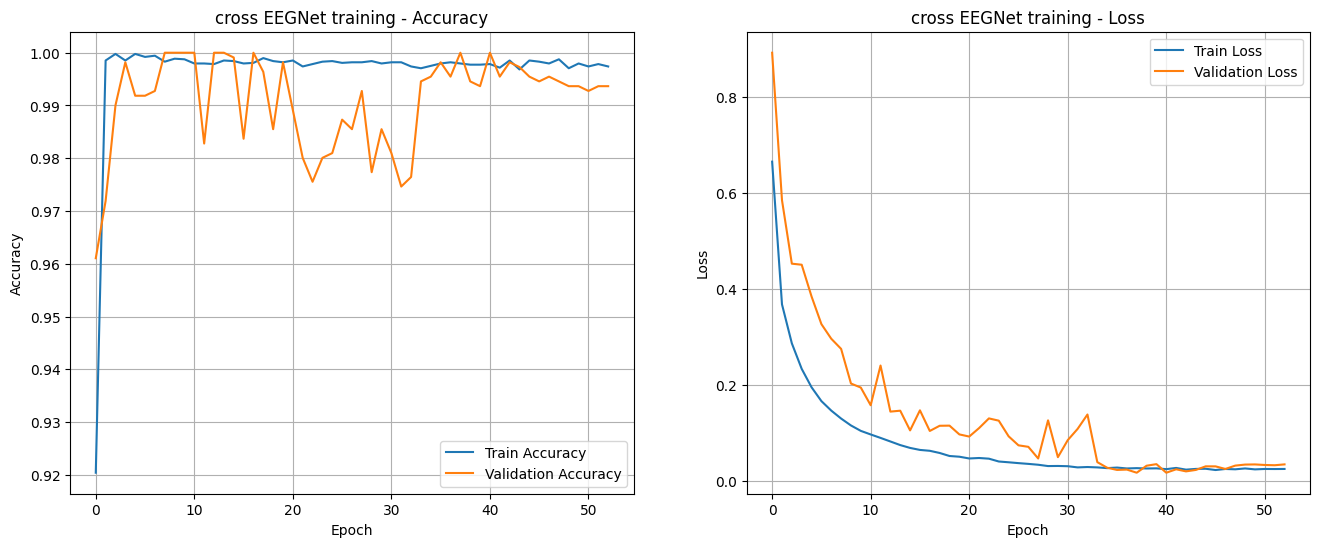

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


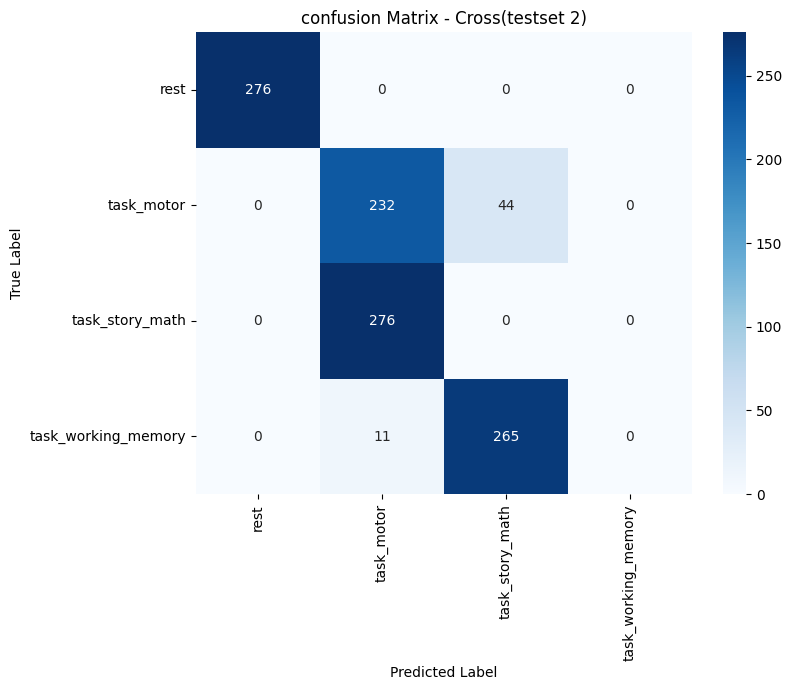

                     precision    recall  f1-score   support

               rest       1.00      1.00      1.00       276
         task_motor       0.45      0.84      0.58       276
    task_story_math       0.00      0.00      0.00       276
task_working_memory       0.00      0.00      0.00       276

           accuracy                           0.46      1104
          macro avg       0.36      0.46      0.40      1104
       weighted avg       0.36      0.46      0.40      1104



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [116]:
plot_history(history_cross, "cross EEGNet training")
y_pred_cross = np.argmax(model.predict(X_test2), axis=1)
plot_confusion_matrix(y_test2, y_pred_cross, TASKS, "confusion Matrix - Cross(testset 2)")
print(classification_report(y_test2, y_pred_cross, target_names=TASKS))